In [62]:
# imports

import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
%matplotlib inline


con = sqlite3.connect(r'C:\Users\praya\OneDrive\Desktop\Data Exploration\database.sqlite')

In [63]:
tables = pd.read_sql("""SELECT *
                        FROM sqlite_master
                        WHERE type='table';""", con)
tables

# Note that the actual data is taken from kaggle and each table and the corresponding column had been observed in detail

,type,name,tbl_name,rootpage,sql
0,table,sqlite_sequence,sqlite_sequence,4,"CREATE TABLE sqlite_sequence(name,seq)"
1,table,Player_Attributes,Player_Attributes,11,"CREATE TABLE ""Player_Attributes"" (\n\t`id`\tIN..."
2,table,Player,Player,14,CREATE TABLE `Player` (\n\t`id`\tINTEGER PRIMA...
3,table,Match,Match,18,CREATE TABLE `Match` (\n\t`id`\tINTEGER PRIMAR...
4,table,League,League,24,CREATE TABLE `League` (\n\t`id`\tINTEGER PRIMA...
5,table,Country,Country,26,CREATE TABLE `Country` (\n\t`id`\tINTEGER PRIM...
6,table,Team,Team,29,"CREATE TABLE ""Team"" (\n\t`id`\tINTEGER PRIMARY..."
7,table,Team_Attributes,Team_Attributes,2,CREATE TABLE `Team_Attributes` (\n\t`id`\tINTE...


In [64]:
# We will now look at each league and their corresponding country by joining on each unique id

league_by_country = pd.read_sql("""Select Country.id, League.name, Country.name 
                                From League 
                                Join Country ON Country.id = League.country_id;""", con)

league_by_country

,id,name,name
0,1,Belgium Jupiler League,Belgium
1,1729,England Premier League,England
2,4769,France Ligue 1,France
3,7809,Germany 1. Bundesliga,Germany
4,10257,Italy Serie A,Italy
5,13274,Netherlands Eredivisie,Netherlands
6,15722,Poland Ekstraklasa,Poland
7,17642,Portugal Liga ZON Sagres,Portugal
8,19694,Scotland Premier League,Scotland
9,21518,Spain LIGA BBVA,Spain


In [34]:
# List of all teams; due to the size of the list, we will limit to 15 teams by ascending order

team = pd.read_sql(""" Select *
                        From Team 
                        Order by team_long_name
                        Limit 15;""", con)
team

,id,team_api_id,team_fifa_api_id,team_long_name,team_short_name
0,16848,8350,29,1. FC Kaiserslautern,KAI
1,15624,8722,31,1. FC Köln,FCK
2,16239,8165,171,1. FC Nürnberg,NUR
3,16243,9905,169,1. FSV Mainz 05,MAI
4,11817,8576,614,AC Ajaccio,AJA
5,11074,108893,111989,AC Arles-Avignon,ARL
6,49116,6493,1714,AC Bellinzona,BEL
7,26560,10217,650,ADO Den Haag,HAA
8,9537,8583,57,AJ Auxerre,AUX
9,9547,9829,69,AS Monaco,MON


In [66]:
# Looking at Player statistics relevant in game

player_stats = pd.read_sql(""" Select PA.player_api_id as Player_api_id,
                                p.player_name as Player_Name, 
                                strftime('%d-%m-%Y',p.birthday) as DOB,
                                max(p.height) as Height,
                                max(p.weight) as Weight,
                                max(PA.overall_rating) as Rating,
                                max(PA.potential) as Potenital,
                                PA.preferred_foot as Preferred_Foot
                            from player p 
                            join player_attributes PA on p.player_api_id=PA.player_api_id 
                            and p.player_fifa_api_id=PA.player_fifa_api_id
                            group by p.player_name """, con)
player_stats.head()

,Player_api_id,Player_Name,DOB,Height,Weight,Rating,Potenital,Preferred_Foot
0,505942,Aaron Appindangoye,29-02-1992,182.88,187,67,71,right
1,155782,Aaron Cresswell,15-12-1989,170.18,146,74,80,left
2,162549,Aaron Doran,13-05-1991,170.18,163,71,78,right
3,30572,Aaron Galindo,08-05-1982,182.88,198,75,82,right
4,23780,Aaron Hughes,08-11-1979,182.88,154,78,81,right


In [71]:
# Join Match data with the rest to analyze seasonal data through aggregate functions for top 5 leagues

seasons_league = pd.read_sql("""Select Country.name as Country_name,
                                 League.name as League_name,
                                 season,
                                 count(distinct stage) as Number_of_stages,
                                 count(distinct away_team.team_long_name) as number_of_teams,
                                 avg(home_team_goal) as avg_home_goals,
                                 avg(away_team_goal) as avg_away_goals,
                                 avg(home_team_goal - away_team_goal) as avg_goal_diff,
                                 avg(home_team_goal + away_team_goal) as avg_goals,
                                 sum(home_team_goal + away_team_goal) as total_goals
                            From Match
                            Join Country on Country.id = Match.country_id
                            Join League on League.id = Match.country_id
                            Left Join Team as away_team on away_team.team_api_id = Match.away_team_api_id
                            Left Join Team as home_team on away_team.team_api_id = Match.home_team_api_id
                            Where Country_name in ('England', 'Spain', 'Germany', 'Italy', 'France')
                            Group by Country.name, season, League.name
                            Having count(distinct stage) > 10
                            Order by season DESC;""", con)

seasons_league

,Country_name,League_name,season,Number_of_stages,number_of_teams,avg_home_goals,avg_away_goals,avg_goal_diff,avg_goals,total_goals
0,England,England Premier League,2015/2016,38,20,1.492105,1.207895,0.284211,2.700000,1026
1,France,France Ligue 1,2015/2016,38,20,1.436842,1.089474,0.347368,2.526316,960
2,Germany,Germany 1. Bundesliga,2015/2016,34,18,1.565359,1.264706,0.300654,2.830065,866
3,Italy,Italy Serie A,2015/2016,38,20,1.471053,1.105263,0.365789,2.576316,979
4,Spain,Spain LIGA BBVA,2015/2016,38,20,1.618421,1.126316,0.492105,2.744737,1043
5,England,England Premier League,2014/2015,38,20,1.473684,1.092105,0.381579,2.565789,975
6,France,France Ligue 1,2014/2015,38,20,1.410526,1.081579,0.328947,2.492105,947
7,Germany,Germany 1. Bundesliga,2014/2015,34,18,1.588235,1.166667,0.421569,2.754902,843
8,Italy,Italy Serie A,2014/2015,38,20,1.498681,1.187335,0.311346,2.686016,1018
9,Spain,Spain LIGA BBVA,2014/2015,38,20,1.536842,1.118421,0.418421,2.655263,1009


<AxesSubplot:title={'center':'Average Goals per Game Over the Seasons'}>

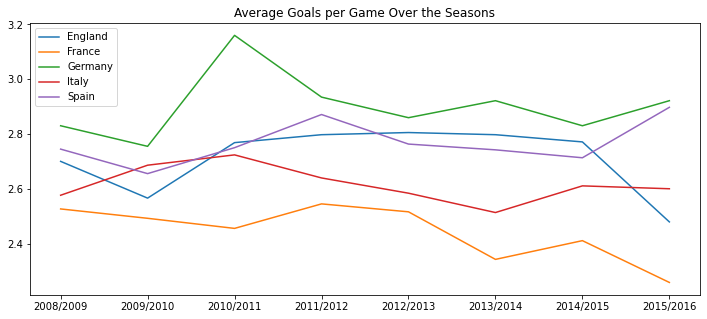

In [72]:
# Graph average goals scored over the seasons  

df = pd.DataFrame(index=np.sort(seasons_league['season'].unique()), columns=seasons_league['Country_name'].unique())

df.loc[:,'England']   = list(seasons_league.loc[seasons_league['Country_name']=='England','avg_goals'])
df.loc[:,'France']   = list(seasons_league.loc[seasons_league['Country_name']=='France','avg_goals'])
df.loc[:,'Spain']   = list(seasons_league.loc[seasons_league['Country_name']=='Spain','avg_goals'])
df.loc[:,'Italy']   = list(seasons_league.loc[seasons_league['Country_name']=='Italy','avg_goals'])
df.loc[:,'Germany']   = list(seasons_league.loc[seasons_league['Country_name']=='Germany','avg_goals'])

df.plot(figsize=(12,5),title='Average Goals per Game Over the Seasons')

From the above graph it can be observed that total number of goals scored in each season does not have a strong correlation with time (seasons). Nevertheless, France has seen a slight increase in average goals scored between 2008-2016. As well, Germany saw almost 3.2 goals per game in the 2013/14 season which indicates a highly entertaining season full of goals.

<AxesSubplot:title={'center':'Average goal difference in top 5 leagues over the seasons'}>

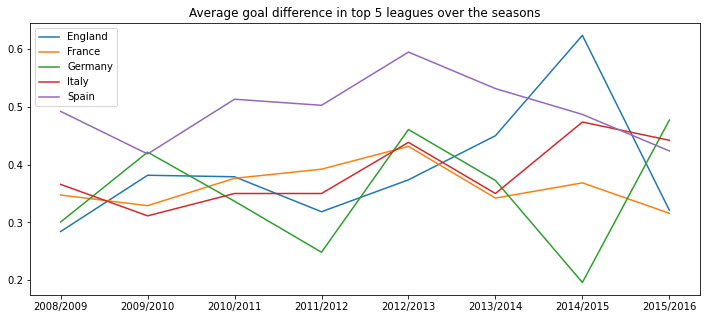

In [73]:
# Graph for Average goal difference over the seasons in the top 5 leagues

df = pd.DataFrame(index=np.sort(seasons_league['season'].unique()), columns=seasons_league['Country_name'].unique())

df.loc[:,'England']   = list(seasons_league.loc[seasons_league['Country_name']=='England','avg_goal_diff'])
df.loc[:,'France']   = list(seasons_league.loc[seasons_league['Country_name']=='France','avg_goal_diff'])
df.loc[:,'Spain']   = list(seasons_league.loc[seasons_league['Country_name']=='Spain','avg_goal_diff'])
df.loc[:,'Italy']   = list(seasons_league.loc[seasons_league['Country_name']=='Italy','avg_goal_diff'])
df.loc[:,'Germany']   = list(seasons_league.loc[seasons_league['Country_name']=='Germany','avg_goal_diff'])

df.plot(figsize=(12,5),title='Average goal difference in top 5 leagues over the seasons')

The above graph shows that the English League had the highest averge goal difference in 2009/10, indicating that the difference in quality between the top teams and the rest were too high. In the same season, the difference in quality between teams in the German league was low, indicated by low goal difference. Moreover, due to the influx of revenue in the English league, the quality of teams has risen over the years which is why the average goal difference sees a steady decline. On the other hand, the Spanish league is dominated by powerhouses like Real Madrid and Barcelona who greatly contribute to the high goal difference. 